#**1. Overview**

----------------------------------------------------------------------------
<br> 
##**1.1 Objective:** <br>

To create a system which is able to remove humans from an image. 

![picture](https://drive.google.com/uc?export=view&id=1l8rLJ5KJPX93NzFQszP9rJP-PApH2QQi)
<br> <br> 

----------------------------------------------------------------------------
##**1.2 Methodology:** <br>

![picture](https://drive.google.com/uc?export=view&id=1La3IuU3mgF07tV0O4HjK6fIwmZcdDyQp)


#**2. Pre-Configuration**

In [1]:
%tensorflow_version 1.x

# Imports
from PIL import Image
from pycocotools.coco import COCO
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau

import os, sys, math, random, matplotlib
import requests
import numpy as np
import tensorflow as tf
import skimage.io as io
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [2]:
# Check for GPU 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**3. Preparing Dataset**

In [4]:
# Download Coco dataset's annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

--2021-04-20 13:28:56--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.1.108
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.1.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  17.0MB/s    in 16s     

2021-04-20 13:29:12 (15.0 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [5]:
# Directory initialization
!mkdir CocoDataset
!mkdir CocoDataset/Annotations
!mkdir CocoDataset/Images
!mkdir CocoDataset/Masks

In [6]:
# Move training and validation annotations files to desired folder
!mv "/content/annotations/instances_train2017.json" "/content/CocoDataset/Annotations"
!mv "/content/annotations/instances_val2017.json" "/content/CocoDataset/Annotations"

In [7]:
# Obtain the class id's corresponding class name in the annotation category list
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

In [8]:
# Instantiate COCO specifying the annotations json path
annFile_val = '/content/CocoDataset/Annotations/instances_val2017.json'
coco_val = COCO(annFile_val)
# Load the categories in a variable
catIDs_val = coco_val.getCatIds()
cats_val = coco_val.loadCats(catIDs_val)

print(cats_val)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'n

In [9]:
# Instantiate COCO specifying the annotations json path
annFile_train = '/content/CocoDataset/Annotations/instances_train2017.json'
coco_train = COCO(annFile_train)
# Load the categories in a variable
catIDs_train = coco_train.getCatIds()
cats_train = coco_train.loadCats(catIDs_train)

print(cats_train)

loading annotations into memory...
Done (t=17.65s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, '

In [10]:
print('Class name for class id 1 is', getClassName(1, cats_train))

Class name for class id 1 is person


In [11]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['person']

# Fetch class IDs only corresponding to the filterClasses
catIds_train = coco_train.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds_train = coco_train.getImgIds(catIds=catIds_train)
images_train = coco_train.loadImgs(imgIds_train)
print("Number of images containing all the classes:", len(imgIds_train))

# Fetch class IDs only corresponding to the filterClasses
catIds_val = coco_val.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds_val = coco_val.getImgIds(catIds=catIds_val)
images_val = coco_val.loadImgs(imgIds_val)
print("Number of images containing all the classes:", len(imgIds_val))

Number of images containing all the classes: 64115
Number of images containing all the classes: 2693


In [12]:
# Custom function to download all images containing persons class
def cocoImageDownload(coco, images, counter, catIds, cats, downloadCount):
  # Loop through all valid images and process them
  img_no = 0;
  for img_pos in range(len(images)):
      if(img_pos == downloadCount - 1):
        break
      img_no = img_pos
      print("Downloading Image " + str(img_no) + "/" + str(len(images) - 1) + "---- /content/CocoDataset/Images/person" + str(img_pos + counter) + ".jpg")
      img = images[img_pos]
      # Download and save image as jpg format
      with open('/content/CocoDataset/Images/person' + str(img_pos + counter) + '.jpg', 'wb') as handler:
        handler.write(requests.get(img['coco_url']).content)
      # Retrieve all annotation IDs related to the image
      annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
      anns = coco.loadAnns(annIds)
      # Initialize a color/binary mask
      mask = np.zeros((img['height'],img['width']))
      # Process every detected annotated segementation
      for i in range(len(anns)):
          className = getClassName(anns[i]['category_id'], cats)
          pixel_value = filterClasses.index(className)+1
          mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
          mask = np.where(mask>0,1,0)
      # Save masks as Image
      mask_img = Image.fromarray((mask*255.0).astype(np.uint8))
      mask_img_name = '/content/CocoDataset/Masks/person' + str(img_pos + counter) + '_mask.jpg'
      mask_img.save(mask_img_name)
      if(img_pos == downloadCount - 1):
        break
  return img_no + 1

In [13]:
# Download n images with person class from the training set
n = 50;
final_counter = cocoImageDownload(coco_train, images_train, 0, catIds_train, cats_train, n)
print(final_counter)

49


{'license': 1, 'file_name': '000000524338.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000524338.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-17 11:29:07', 'flickr_url': 'http://farm4.staticflickr.com/3383/3507659926_3933fc056f_z.jpg', 'id': 524338}


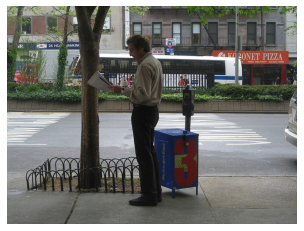

In [14]:
# Choose a random image to view
randint = random.randint(0,n)
img = images_train[randint]
print(img)
file_name = '/content/CocoDataset/Images/person' + str(randint) + '.jpg'
I = io.imread(file_name)/255.0
plt.axis('off')
plt.imshow(I)
plt.show()

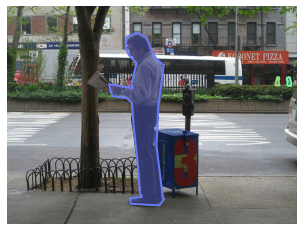

In [15]:
# Overlay annotated segmentation
plt.imshow(I)
plt.axis('off')
annIds = coco_train.getAnnIds(imgIds=img['id'], catIds=catIds_train, iscrowd=None)
anns = coco_train.loadAnns(annIds)
coco_train.showAnns(anns)

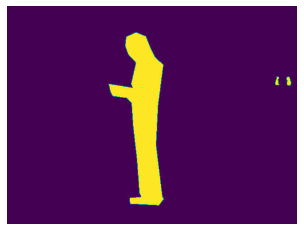

In [16]:
# Obtain corresponding image mask and display
file_name = '/content/CocoDataset/Masks/person' + str(randint) + '_mask.jpg'
I = io.imread(file_name)
plt.axis('off')
plt.imshow(I)

In [17]:
# Download another n person images from the validation set
n = 50
final_counter = cocoImageDownload(coco_val, images_val, final_counter, catIds_val, cats_val, n)
print(final_counter)

49


#**4. Model**

In [18]:
!apt install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 31 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 

In [19]:
!svn export https://github.com/Jeremylsw/Deep-Learning/trunk/Person_Remover/coco.py
!svn checkout https://github.com/Jeremylsw/Deep-Learning/trunk/Person_Remover/mrcnn

A    coco.py
Export complete.
A    mrcnn/__init__.py
A    mrcnn/config.py
A    mrcnn/model.py
A    mrcnn/parallel_model.py
A    mrcnn/utils.py
A    mrcnn/visualize.py
Checked out revision 11.


In [20]:
!cp "/content/drive/MyDrive/Projects/SGInnovate/ACV/mask_rcnn_coco.h5" "/content"

In [21]:
from mrcnn import utils
from mrcnn import visualize
import coco
import warnings
import mrcnn.model as modellib
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [22]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [23]:
IMAGE_DIR = "/content/CocoDataset/Images"
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.h5', config=config)

# Load weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


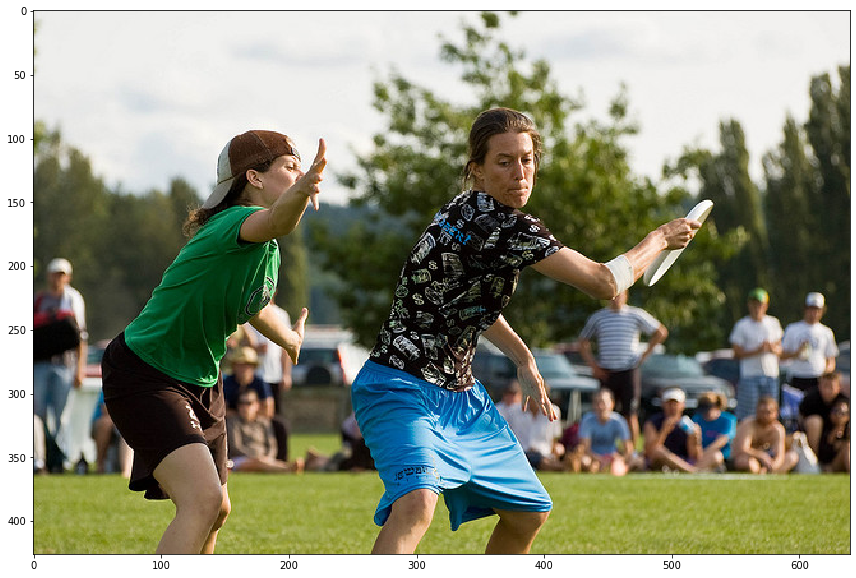

In [24]:
# Load a image from the images folder
Test_img_dir = "/content/CocoDataset/Images/person13.jpg"
image = io.imread(Test_img_dir)

# original image
plt.figure(figsize=(12,10))
io.imshow(image)

In [25]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



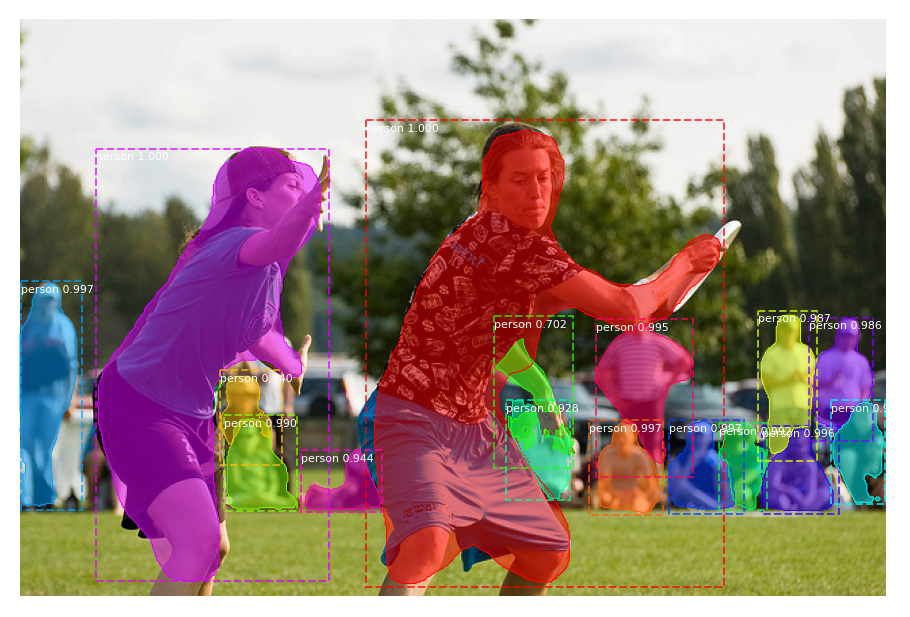

In [26]:
# Run detection only on humans
results = model.detect([image], verbose=1)

# Visualize results
# for first image (as we're providing single image only)
r = results[0]
# print(r)  # dictionary of np arrays

# get indices corresponding to unwanted classes
indices_to_remove = np.where(r['class_ids'] != 1)

# remove corresponding entries from `r`
new_class_ids = np.delete(r['class_ids'], indices_to_remove, axis=0)
new_rois = np.delete(r['rois'], indices_to_remove, axis=0)
new_scores = np.delete(r['scores'], indices_to_remove, axis=0)
new_masks = np.delete(r['masks'], indices_to_remove, axis=2)

visualize.display_instances(image, new_rois, new_masks, new_class_ids, 
                            class_names, new_scores)

In [27]:
# Convert masks to binary
mask = r['masks']
mask = mask.astype(int)
mask.shape

(426, 640, 20)

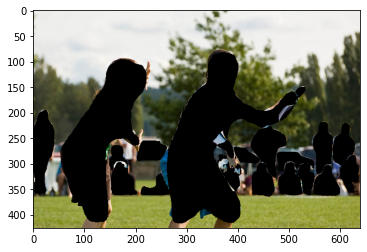

In [28]:
# Remove all humans from image
output = io.imread(Test_img_dir)
for i in range(mask.shape[2]):
    temp = io.imread(Test_img_dir)
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    output = output - temp
plt.imshow(output)


#**5. Training Custom Dataset**

This section shows how to train a custom dataset on the Mask-RCNN model instead of relying on COCO dataset.

The tedious part about training a custom dataset is to annotate the input image data. Annotation can be done on this [site](https://www.robots.ox.ac.uk/~vgg/software/via/via.html).

The following image shows some of the annotated custom image:
![picture](https://drive.google.com/uc?export=view&id=1Amzqlofk_BycxzPZW5U4LfodsIGElaqv)

In [29]:
!svn checkout https://github.com/Jeremylsw/Deep-Learning/trunk/Person_Remover/custom
!svn export https://github.com/Jeremylsw/Deep-Learning/trunk/Person_Remover/custom.py

A    custom/train
A    custom/train/Human01.jpg
A    custom/train/Human02.jpg
A    custom/train/Human03.png
A    custom/train/Human04.jpg
A    custom/train/Human06.jpg
A    custom/train/Human08.jpg
A    custom/train/Human09.jpg
A    custom/train/Human10.jpg
A    custom/train/annotations.json
A    custom/val
A    custom/val/Human05.jpg
A    custom/val/Human07.jpg
A    custom/val/annotations.json
Checked out revision 11.
A    custom.py
Export complete.


In [30]:
!python /content/custom.py train --dataset=custom --weights=coco

Using TensorFlow backend.
Weights:  coco
Dataset:  custom
Logs:  /logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn

In [31]:
#########################################################################
## Load trained model
#########################################################################
import custom
%matplotlib inline 
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "/content/drive/MyDrive/Projects/SGInnovate/ACV/logs")
BALLON_WEIGHTS_PATH = "mask_rcnn_object_0010.h5"  
 
config = custom.CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "content/custom/")
 
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
config = InferenceConfig()
config.display()
 
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
     
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
 
# Load validation dataset
dataset = custom.CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
 
# Must call before using the dataset
dataset.prepare()
 
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
DEVICE = "/gpu:0"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
 
weights_path = model.find_last()
 
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

image ID: object.Human05.jpg (0) /content/custom/val/Human05.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


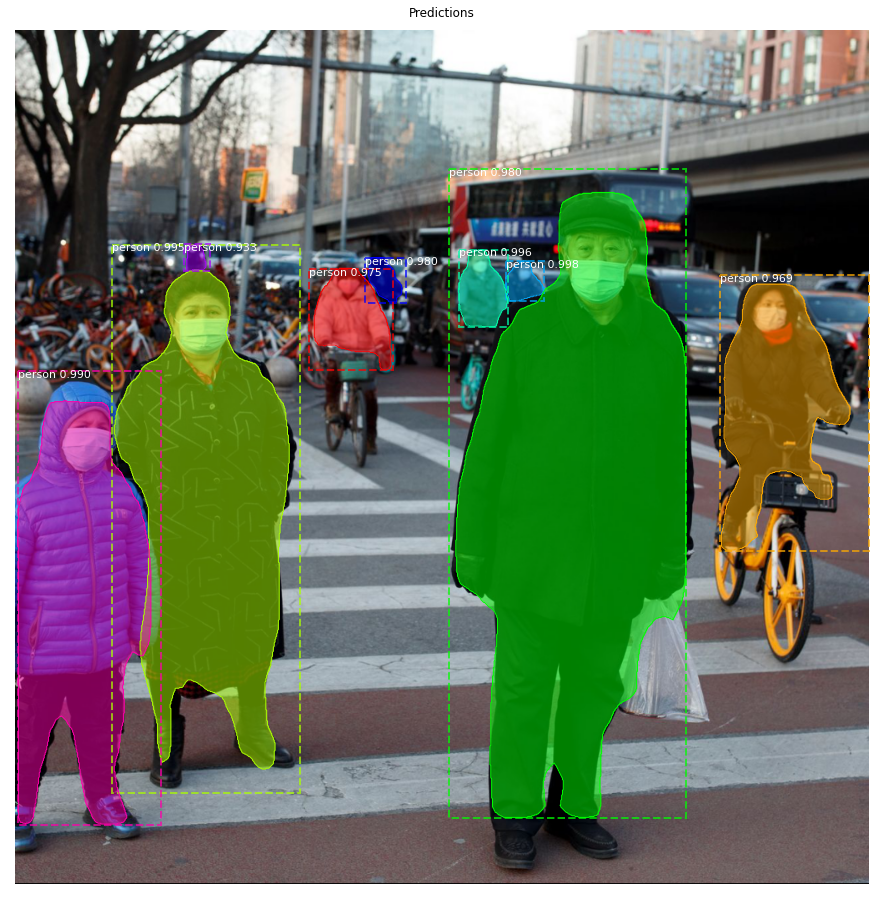

In [131]:
#########################################################################
## Run Inference on random image in validation set
#########################################################################
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
 
# Run object detection
results = model.detect([image], verbose=1)
 
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [132]:
# Convert masks to binary
mask = r['masks']
mask = 1 - mask.astype(int)
print(mask.shape)

(1024, 1024, 9)


(1024, 1024, 3)


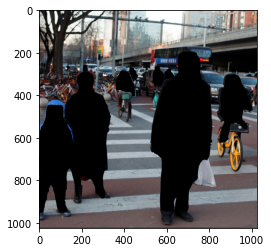

In [133]:
# Remove all humans from image
output = image
for i in range(mask.shape[2]): # For number of masks
    for j in range(image.shape[2]): # For RGB planes
        output[:,:,j] = output[:,:,j] * mask[:,:,i]
print(output.shape)
plt.imshow(output)

#**6. References**



*   [Implementing Mask R-CNN for Image Segmentation](https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/) 
*   [Mask-RCNN Model Github](https://github.com/matterport/Mask_RCNN)
*   [Mask-RCNN Custom Training](https://github.com/SriRamGovardhanam/wastedata-Mask_RCNN-multiple-classes)
*   [Tutorial on Annotating Datasets](https://www.youtube.com/watch?v=1u-dm5JMH1Q&ab_channel=CodeWithAarohi)


#**To-Dos**

Pix2pix

#Debugging

{0: 79581, 1: 968995}

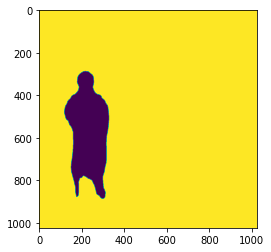

In [117]:
test = np.reshape(mask[:,:,2], (1024,1024))
test.shape
plt.imshow(test)


# Verify that masks only contain (unique classes + 1) unique pixel values
unique, counts = np.unique(test, return_counts=True)
dict(zip(unique, counts))

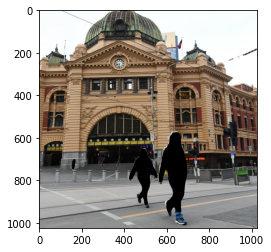

In [130]:
plt.imshow(image)